# 凯利公式 —— 单个标的 + 无风险产品

## wikipedia
Wikipedia [Kelly Criterion](https://en.wikipedia.org/wiki/Kelly_criterion)

> $f^* = \displaystyle\frac{\mu - r}{\sigma^2 }$

$f^*$ 的资金投资到股票或ETF，剩余的 $(1 - f^*)$ 的资金投资到bond。

## Thorpe 论文——投资组合
### Kelly criterion in blackjack, sports betting, and the stock market

$X$是随机变量，$P(X=m+s) = P(X=m-s) = 0.5$, $E(X)=m$, $Var(X)=s^2$，初始资本 $V_0$，比例 $f$ 的投资每单位收益$X$，$(1-f)$ 则投资例如Treasury bills、Bond等，每单位收益 $r$：

1. $V(f) = V_0 + V_0 (1-f) \cdot r + V_0 f \cdot X = V_0(1 + (1-f) \cdot r + f \cdot X) = V_0(1 + r + f \cdot (X-r))$，最末即 **超额收益**；
2. $g_\infty(f) \equiv r + f(m-r) - \displaystyle\frac{s^2 f^2}{2}$，其中的 $(m-r)$ 即 **超额收益**。

有：
1. $f^* = \displaystyle\frac{(m-r)}{s^2}$，可通过$\displaystyle\frac{\partial{g_\infty(f)}}{\partial{f}}=0$得到；
2. $g_\infty(f) = r + f(m-r) - \displaystyle\frac{s^2 f^2}{2}$
3. $g_\infty(f^*) = r + \displaystyle\frac{(m-r)^2}{2s^2}$
4. $Var(G_\infty(f)) = s^2 f^2$
5. $Sdev(G_\infty(f)) = sf $

等式(7.2)，等式(7.3)，注意其中的 $\displaystyle\frac{m-r}{s}$ 即sharpe ratio，$g$ 为Compound Annual Growth Rate。


## 策略调整
- $f_i = \displaystyle{ m_i \over {s_i}^2 }$
- $g_i = r + m_i - \displaystyle{{s_i}^2 \over 2}$

其中:
- $r$ 为无风险利率；
- $m_i$ 为平均超额收益 mean excess return；
- $s_i$ 为 $m_i$ 的标准差standard deviation；
- $g_i$ 对应 <font color=red>**全部资金投资股票**</font>，等价于Thorpe公式中 $g_\infty(f)$ 取 $f=1.0$。

# A股主要ETF标的测试

**注意：代码中假定 ETF可以做空，实际A股融券很难，可考虑股指期货。**

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import logging
import log_setup
log_setup.setup()

In [2]:
def datafile_info():
    res = {}
    with open('./datafiles_info.txt', encoding='utf8') as fh:
        for line in fh:
            line = line.strip()
            if not line.startswith('AssetInfo'):
                continue
            p1 = line.find('{')
            p2 = line.find(',', p1+1)
            p3 = line.find(',', p2+1)
            code = line[p1+1:p2]
            name = line[p2+2:p3]
            res[code] = name
    return res

code2name = datafile_info()
print(code2name)

{'510050.SH': '上证50ETF', '510300.SH': '沪深300ETF', '510500.SH': '中证500ETF', '159915.SZ': '创业板ETF', '159949.SZ': '创业板50ETF', '588000.SH': '科创50ETF', '518880.SH': '黄金ETF', '159781.SZ': '双创50ETF', '159601.SZ': 'A50ETF'}


In [3]:
df = pd.read_excel('datafiles/159949.SZ_2016-07-22_2023-04-25.xlsx', header=0, index_col=0)
df.shape

(1643, 7)

In [4]:
df.head()

,timestamp,open,high,low,close,amount,volume
2016-07-22 01:30:00,1469151000,0.992,0.997,0.980,0.987,151182352.0,152786635
2016-07-25 01:30:00,1469410200,0.985,0.991,0.976,0.978,56574116.0,57524377
2016-07-26 01:30:00,1469496600,0.978,0.996,0.978,0.995,64502032.0,65106373
2016-07-27 01:30:00,1469583000,0.997,0.999,0.931,0.940,82250656.0,85506942
2016-07-28 01:30:00,1469669400,0.940,0.946,0.916,0.933,28062294.0,30032572


In [5]:
df.tail()

,timestamp,open,high,low,close,amount,volume
2023-04-19 01:30:00,1681867800,1.030,1.032,1.021,1.023,5.711292e+08,557253733
2023-04-20 01:30:00,1681954200,1.022,1.022,1.002,1.005,8.794248e+08,872025823
2023-04-21 01:30:00,1682040600,1.007,1.012,0.987,0.988,8.399854e+08,840351591
2023-04-24 01:30:00,1682299800,0.988,0.988,0.960,0.965,1.168651e+09,1204231468
2023-04-25 01:30:00,1682386200,0.967,0.969,0.940,0.944,1.041406e+09,1097391616


<font color=red>以下计算取无风险利率 $r = 0.02$。</font>

In [6]:
k_annual_risk_free_rate = 0.02 # 假设无风险利率年化为 2%
k_days_per_year = 252

In [7]:
def compute(code, name, start, end, df):
    daily_return = df.close.pct_change()
    # m
    avg_annual_return        = daily_return.mean() * k_days_per_year
    # m - r
    avg_annual_excess_return = avg_annual_return - k_annual_risk_free_rate
    #
    sd_excess_return         = (daily_return - k_annual_risk_free_rate / k_days_per_year).std()
    # s
    annual_sd_excess_return  = sd_excess_return * np.sqrt(k_days_per_year)
    # (m - r) / s
    sharpe_ratio   = avg_annual_excess_return / annual_sd_excess_return
    # f
    kelly_leverage = avg_annual_excess_return / (annual_sd_excess_return ** 2)
    # g_i
    comp_growth_rate = avg_annual_return - annual_sd_excess_return ** 2 / 2
    # g_infty
    comp_growth_rate_inf = k_annual_risk_free_rate + 0.5 * sharpe_ratio ** 2
    return (code, name, start, end,
            avg_annual_return, avg_annual_excess_return,
            sd_excess_return, annual_sd_excess_return, sharpe_ratio,
            kelly_leverage, comp_growth_rate, comp_growth_rate_inf,
            df.shape[0])

In [8]:
stats_overall = []
stats_yearly  = []
for file in ['./datafiles/159601.SZ_2021-11-08_2023-04-25.xlsx',
             './datafiles/159781.SZ_2021-07-05_2023-04-25.xlsx',
             './datafiles/159915.SZ_2011-12-09_2023-04-25.xlsx',
             './datafiles/159949.SZ_2016-07-22_2023-04-25.xlsx',
             './datafiles/510050.SH_2005-02-23_2023-04-25.xlsx',
             './datafiles/510300.SH_2012-05-28_2023-04-25.xlsx',
             './datafiles/510500.SH_2013-03-15_2023-04-25.xlsx',
             './datafiles/518880.SH_2013-07-29_2023-04-25.xlsx',
             './datafiles/588000.SH_2020-11-16_2023-04-25.xlsx',
            ]:
    last_slash = file.rfind('/')
    underscore = file.find('_', last_slash)
    code = file[last_slash+1:underscore]
    name = code2name[code]
    df = pd.read_excel(file, header=0, index_col=0)
    stats_overall.append(compute(
        code, name, df.index[0].strftime('%Y.%m.%d'), df.index[-1].strftime('%Y.%m.%d'), df))

    if 1:
        years = sorted(df.index.year.unique())
        for idx in range(0, len(years)):
            start = '{:4d}.01.01'.format(years[idx])
            end   = '{:4d}.12.31'.format(years[idx])
            part_df = df[start:end]
            if part_df.shape[0] < 100:
                logging.info('{} {}: skip year {}, not enough data #{}'.format(
                    code, name, years[idx], part_df.shape[0]))
                continue
            stats_yearly.append(compute(code, name, start, end, part_df))

columns = ['code', 'name', 'start', 'end',
           'AvgAnnRet', 'AvgAnnExRet',
           'DayExRetSD', 'AnnExRetSD',
           'SharpeRatio', 'KellyLever', 'CAGR1', 'CAGR2',
           'Size']
df_overall = pd.DataFrame(stats_overall, columns=columns)
df_yearly  = pd.DataFrame(stats_yearly, columns=columns)

[2023-04-26 03:57:28,683] [INFO]	[2606810087.py:28:<module>] 159601.SZ A50ETF: skip year 2021, not enough data #40
[2023-04-26 03:57:28,683] [INFO]	[2606810087.py:28:<module>] 159601.SZ A50ETF: skip year 2023, not enough data #75
[2023-04-26 03:57:28,808] [INFO]	[2606810087.py:28:<module>] 159781.SZ 双创50ETF: skip year 2023, not enough data #75
[2023-04-26 03:57:29,137] [INFO]	[2606810087.py:28:<module>] 159915.SZ 创业板ETF: skip year 2011, not enough data #16
[2023-04-26 03:57:29,178] [INFO]	[2606810087.py:28:<module>] 159915.SZ 创业板ETF: skip year 2023, not enough data #75
[2023-04-26 03:57:29,397] [INFO]	[2606810087.py:28:<module>] 159949.SZ 创业板50ETF: skip year 2023, not enough data #75
[2023-04-26 03:57:29,972] [INFO]	[2606810087.py:28:<module>] 510050.SH 上证50ETF: skip year 2023, not enough data #75
[2023-04-26 03:57:30,367] [INFO]	[2606810087.py:28:<module>] 510300.SH 沪深300ETF: skip year 2023, not enough data #75
[2023-04-26 03:57:30,677] [INFO]	[2606810087.py:28:<module>] 510500.SH 中证5

# 整个历史周期

In [9]:
df_overall

,code,name,start,end,AvgAnnRet,AvgAnnExRet,DayExRetSD,AnnExRetSD,SharpeRatio,KellyLever,CAGR1,CAGR2,Size
0,159601.SZ,A50ETF,2021.11.08,2023.04.25,-0.145527,-0.165527,0.012301,0.195267,-0.847697,-4.341228,-0.164591,0.379295,357
1,159781.SZ,双创50ETF,2021.07.05,2023.04.25,-0.257432,-0.277432,0.015535,0.246612,-1.124975,-4.561727,-0.287840,0.652784,440
2,159915.SZ,创业板ETF,2011.12.09,2023.04.25,0.147151,0.127151,0.020814,0.330411,0.384827,1.164692,0.092565,0.094046,2763
3,159949.SZ,创业板50ETF,2016.07.22,2023.04.25,0.034474,0.014474,0.018105,0.287409,0.050359,0.175217,-0.006828,0.021268,1643
4,510050.SH,上证50ETF,2005.02.23,2023.04.25,0.115492,0.095492,0.016755,0.265984,0.359014,1.349755,0.080118,0.084445,4420
5,510300.SH,沪深300ETF,2012.05.28,2023.04.25,0.082992,0.062992,0.014677,0.232996,0.270357,1.160355,0.055849,0.056547,2655
6,510500.SH,中证500ETF,2013.03.15,2023.04.25,0.109150,0.089150,0.016994,0.269773,0.330464,1.224971,0.072761,0.074603,2459
7,518880.SH,黄金ETF,2013.07.29,2023.04.25,0.061328,0.041328,0.008223,0.130529,0.316621,2.425680,0.052809,0.070124,2372
8,588000.SH,科创50ETF,2020.11.16,2023.04.25,-0.083447,-0.103447,0.015612,0.247834,-0.417403,-1.684207,-0.114157,0.107113,594


# 每一年

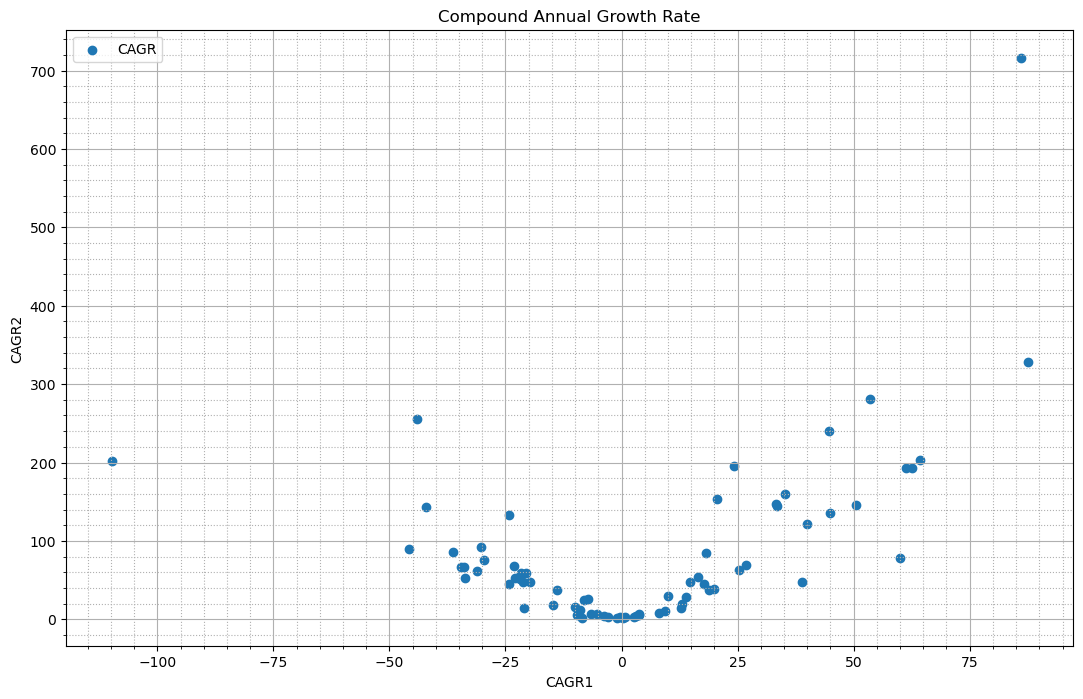

In [10]:
plt.figure(figsize=(13, 8), dpi=100)
plt.scatter(df_yearly.CAGR1 * 100, df_yearly.CAGR2 * 100, marker='o', label='CAGR')
plt.xlabel('CAGR1')
plt.ylabel('CAGR2')
plt.title('Compound Annual Growth Rate')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(25))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(5))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(20))
plt.grid(which='major', axis='both', ls='-')
plt.grid(which='minor', axis='both', ls=':')
plt.legend(loc='upper left')

# TODO：按年份绘直方图

In [11]:
df_yearly[:50]

,code,name,start,end,AvgAnnRet,AvgAnnExRet,DayExRetSD,AnnExRetSD,SharpeRatio,KellyLever,CAGR1,CAGR2,Size
0,159601.SZ,A50ETF,2022.01.01,2022.12.31,-0.195434,-0.215434,0.013674,0.217075,-0.992442,-4.571895,-0.218995,0.512471,242
1,159781.SZ,双创50ETF,2021.01.01,2021.12.31,-0.268097,-0.288097,0.014936,0.237108,-1.215045,-5.124443,-0.296207,0.758167,123
2,159781.SZ,双创50ETF,2022.01.01,2022.12.31,-0.275468,-0.295468,0.017041,0.270511,-1.092259,-4.037767,-0.312056,0.616515,242
3,159915.SZ,创业板ETF,2012.01.01,2012.12.31,0.048293,0.028293,0.018007,0.285846,0.098981,0.346273,0.007439,0.024899,243
4,159915.SZ,创业板ETF,2013.01.01,2013.12.31,0.682928,0.662928,0.021355,0.339006,1.955507,5.768361,0.625466,1.932005,238
5,159915.SZ,创业板ETF,2014.01.01,2014.12.31,0.126086,0.106086,0.016034,0.254535,0.416781,1.637423,0.093691,0.106853,245
6,159915.SZ,创业板ETF,2015.01.01,2015.12.31,0.800844,0.780844,0.039896,0.633331,1.232916,1.946718,0.600290,0.780041,244
7,159915.SZ,创业板ETF,2016.01.01,2016.12.31,-0.152603,-0.172603,0.021436,0.340278,-0.507240,-1.490662,-0.210497,0.148646,244
8,159915.SZ,创业板ETF,2017.01.01,2017.12.31,-0.124789,-0.144789,0.010857,0.172346,-0.840106,-4.874528,-0.139641,0.372889,244
9,159915.SZ,创业板ETF,2018.01.01,2018.12.31,-0.305462,-0.325462,0.017966,0.285203,-1.141159,-4.001209,-0.346133,0.671121,243


In [12]:
df_yearly.shape[0] > 50 and df_yearly[50:]

,code,name,start,end,AvgAnnRet,AvgAnnExRet,DayExRetSD,AnnExRetSD,SharpeRatio,KellyLever,CAGR1,CAGR2,Size
50,510500.SH,中证500ETF,2013.01.01,2013.12.31,0.155547,0.135547,0.014222,0.225761,0.600400,2.659450,0.130063,0.200240,193
51,510500.SH,中证500ETF,2014.01.01,2014.12.31,0.354357,0.334357,0.012469,0.197936,1.689221,8.534194,0.334768,1.446734,245
52,510500.SH,中证500ETF,2015.01.01,2015.12.31,0.533531,0.513531,0.033916,0.538395,0.953819,1.771595,0.388597,0.474885,243
53,510500.SH,中证500ETF,2016.01.01,2016.12.31,-0.052168,-0.072168,0.018649,0.296037,-0.243780,-0.823477,-0.095987,0.049714,244
54,510500.SH,中证500ETF,2017.01.01,2017.12.31,0.007715,-0.012285,0.009351,0.148443,-0.082762,-0.557532,-0.003303,0.023425,244
55,510500.SH,中证500ETF,2018.01.01,2018.12.31,-0.391860,-0.411860,0.015419,0.244774,-1.682614,-6.874155,-0.421817,1.435595,243
56,510500.SH,中证500ETF,2019.01.01,2019.12.31,0.295147,0.275147,0.014881,0.236233,1.164727,4.930422,0.267244,0.698295,244
57,510500.SH,中证500ETF,2020.01.01,2020.12.31,0.230985,0.210985,0.015656,0.248525,0.848947,3.415940,0.200103,0.380356,243
58,510500.SH,中证500ETF,2021.01.01,2021.12.31,0.158806,0.138806,0.009195,0.145966,0.950951,6.514898,0.148153,0.472154,243
59,510500.SH,中证500ETF,2022.01.01,2022.12.31,-0.188984,-0.208984,0.013804,0.219134,-0.953681,-4.352037,-0.212994,0.474753,242
